<h2> Controller Tunning Method using Genetic Algorithm </h2>

This notebook contents tunning method using genetic algorithms for find candidates gains to a PID Controller and non-linear Lyapunov closed-loop controls for steering robot problem. The GA algorithm is an authoral adaptation of implementation [Burjorjee](https://github.com/burjorjee/speedyGApy) based on Melanie [Mitchell's Book](https://direct.mit.edu/books/book/4675/An-Introduction-to-Genetic-Algorithms).

Python package requirements: matplotlib, numpy, scipy. 


William Henrique (william.martins@ee.ufcg.edu.br) <br>
March 8, 2024

In [1]:
import argparse
from functools import partial
from random import random
from matplotlib.pyplot import figure, plot, xlabel, ylabel, title, axis, legend
import numpy as np
from numpy import arctan2, cos, sin, pi, trapz
from numpy.random import rand, randn
import SpeedyGA_python.speedyGA as ga
from scipy.integrate import solve_ivp, trapezoid

### Introdution

In last exercice two non-linear control laws was developed using Lyapunov Stability Theory,  in this notebook a simple PID controller will be introduced either. And futher the controls parameters will be obtained using a heuristic algorithm.

The control gains can be obtained with non determinitc methods based on heuristcs as the genetic algorithms. The genetic algorithm is a bio-based algorithm that is based on the crossing of traits as occurs in sexual reproduction, where two individuals combine their genes to create a new individual in a process called crossover.

<div align=center>
<img src="figures/CROSS0.gif" width=240>
</div>

This concept allow us to combine the chromossomes of many individuos (population) and combine the best scored ones to generate childs, repeating this processes over generations. The chromossomes can be sliptted in part to represent the genes or the candidate control gains.

A population with 60 bit length can be used to obtain the $k_p$, $k_i$, $k_d$ dividing all the genetic information into equal substrings or different length substrings. By splitting it in 3 equal parts we can represent the control parameters by using q notation.

by using $q = 2^{14}$ we can represent as non-signed numbers in range $[6.103515625e-05, 3.99993896484375]$

In [5]:
def decode_chromosomes(x, nvar):
    # Function to decode the chromosomes of a population
    m, n = x.shape
    # split chromossome bit array into nvar variables
    len_div_k = n // nvar
    result = []
    for i in range(nvar):
        # extract a substring from the chromossome
        bit_array = x[:, i*len_div_k:(i+1)*len_div_k]
        # convert it to a decimal integer
        interger = np.sum(bit_array * 2**(np.arange(len_div_k)[::-1]), axis=1)
        # convert it to a decimal float using q notation keeping 2 bits for interger part
        dec_values = interger / 2**(len_div_k-2)

        result.append(dec_values)
    return np.column_stack(result)

### Go to Goal: PID Control Law
$$

\begin{equation}
\nu=v_0, \phi_d=\tan ^{-1}\left(\frac{y_g-y}{x_g-x}\right), e=\phi_d-\phi, \omega=P I D(e)
\end{equation}
\\

\\
\begin{equation}
\underbrace{\left[\begin{array}{c}
\dot{x} \\
\dot{y} \\
\dot{\phi} \\
\dot{z}_1 \\
\dot{z}_2
\end{array}\right]}_{\dot{\chi}}=\underbrace{\left[\begin{array}{c}
v_0 \cos (\phi) \\
v_0 \sin (\phi) \\
k_i p_d z_1+\left(k_i-k_d p_d^2\right) z_2+\left(k_p+k_d p_d\right) e \\
z_2 \\
-p_d z_2+e
\end{array}\right]}_{\mathrm{f}(\chi)},
\end{equation}
$$

In [8]:
def norm(x, y):
    return np.sqrt(x**2 + y**2)


def pid_control_law(t, state, v0, kp, ki, kd, pd, target=[0, 0], tol=0.01):
    x, y, phi, z1, z2 = state
    xg, yg = target
    
    theta_d = arctan2(yg - y, xg - x)
    e = theta_d - phi
    # e = arctan2(sin(e), cos(e))
    dist = norm(xg-x, yg-x)
    v = v0 if dist > tol else 0

    return np.array([
        v*cos(phi),
        v*sin(phi),
        ki*pd*z1+(ki-kd*pd**2)*z2+(kp+kd*pd)*e,
        z2,
        -pd*z2+e])

### The performance indices
The performace indices or error metrics is commonly used to evaluate controllers, by comparating the error dynamic of closed-loop system. Some of them is listed bellow:
- The Integral absolute error (IAE):
$$\int_{0}^{\inf}|e|dt$$
- The Integral Squared error (ISE):
$$\int_{0}^{\inf}e^2dt$$
- The Integral of Time multiply Absolute Error (ITSA)
$$\int_{0}^{\inf}t|e|dt$$
- Integral of Time Multiply Squared Error (ITSE)
$$\int_{0}^{\inf}te^2dt$$

In [7]:
# Controller metrics func
fIAE = lambda t, e:     trapz(abs(e),   x=t)
fITAE = lambda t, e:    trapz(t*abs(e), x=t)
fISE= lambda t, e :     trapz(e**2,     x=t)
fITSE= lambda t, e:     trapz(t*e**2,   x=t)

### Objective function

by first instace, let define the fitness function as the $\frac{1}{f_{obj}(t, e)}$ where $f_{obj}({t, e})$ is the desired perfomace metric computed for all individuos of the current running population. So, if we want to maximaze the fitness function, the error must be minimizade.

Algorithm overview:
1. Generate a population
2. Evaluate
    - Decode population chromossomes
    - Solve the differential equations
    - compute f(t, e) and the fitness score
2. Crossover
3. Apply Mutation
4. Repeat

In [6]:
def ga_fitting(pop):
    # (Step 2) Evaluate the population
    global v0, pd, tf, target_pos, fobj, initial_state, dt
    popSize, popLen = pop.shape
    gains = decode_chromosomes(pop, 3)
    t = np.arange(0, tf, 50e-3)
    vobj = np.zeros(popSize)
    for i in range(popSize):
        kp = gains[i][0]
        ki = gains[i][1]
        kd = gains[i][2]
        sol = solve_ivp(fun=pid_control_law, t_span=(0, tf), y0=initial_state,
                        args=[v0, kp, ki, kd, pd, target_pos], t_eval=t)
        t = sol.t
        # robot pose
        x = sol.y[0]
        y = sol.y[1]
        phi = sol.y[2]
        
        phi_d = arctan2(y, x)
        e   = phi_d - phi
        # e = arctan2(cos(e), sin(e))
        vobj[i] = fobj(t, e)
        
    return (1.0/vobj)

In [7]:
# Simulation Parameters
v0 = 0.2     # Velocity
pd = 50      # Derivative shift
tf = 30      # Simulation time
dt = 50e-3   # Simulation step time
maxGens = 20 # Max generations

target_pos = [1, 1]
phi_g = arctan2(target_pos[1], target_pos[0])
initial_state = [0, 0, -pi/2, 2e-16, 2e-16]
fobj = fIAE

gen = 000   avgFitness = 0.194  maxfitness = 0.906


c:\Users\willi\OneDrive\Documentos\Automação Inteligente\Atividade 3\SpeedyGA_python\speedyGA.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


gen = 001   avgFitness = 0.357  maxfitness = 0.935
gen = 002   avgFitness = 0.520  maxfitness = 0.952
gen = 003   avgFitness = 0.601  maxfitness = 0.952
gen = 004   avgFitness = 0.656  maxfitness = 0.952
gen = 005   avgFitness = 0.713  maxfitness = 0.968
gen = 006   avgFitness = 0.729  maxfitness = 0.975
gen = 007   avgFitness = 0.759  maxfitness = 0.993
gen = 008   avgFitness = 0.764  maxfitness = 0.993
gen = 009   avgFitness = 0.782  maxfitness = 0.978
gen = 010   avgFitness = 0.774  maxfitness = 0.986
gen = 011   avgFitness = 0.795  maxfitness = 0.979
gen = 012   avgFitness = 0.808  maxfitness = 0.979
gen = 013   avgFitness = 0.821  maxfitness = 0.978
gen = 014   avgFitness = 0.823  maxfitness = 0.990
gen = 015   avgFitness = 0.830  maxfitness = 0.990
gen = 016   avgFitness = 0.830  maxfitness = 0.991
gen = 017   avgFitness = 0.841  maxfitness = 0.990
gen = 018   avgFitness = 0.841  maxfitness = 0.990
gen = 019   avgFitness = 0.846  maxfitness = 0.988


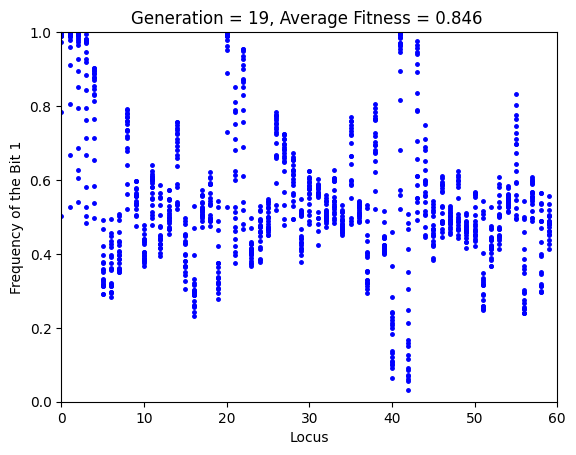

In [90]:
strongers = ga.evolve(fitnessFunction=ga_fitting, 
          length=60, popSize=500, maxGens=maxGens,
          probMutation=0.005)

chr = decode_chromosomes(strongers['DNA'], 3)
score = strongers['score'].max()
np.save('ga_mf=' + str(round(strongers['score'].max(), 4))
, strongers['DNA'])

gen = 000   avgFitness = 0.180  maxfitness = 2.268
gen = 001   avgFitness = 0.468  maxfitness = 2.414
gen = 002   avgFitness = 0.920  maxfitness = 2.668
gen = 003   avgFitness = 1.379  maxfitness = 2.668
gen = 004   avgFitness = 1.701  maxfitness = 2.705
gen = 005   avgFitness = 1.898  maxfitness = 2.709
gen = 006   avgFitness = 1.984  maxfitness = 2.709
gen = 007   avgFitness = 2.012  maxfitness = 2.709
gen = 008   avgFitness = 2.073  maxfitness = 2.781
gen = 009   avgFitness = 2.146  maxfitness = 2.781
gen = 010   avgFitness = 2.190  maxfitness = 2.802
gen = 011   avgFitness = 2.164  maxfitness = 2.791
gen = 012   avgFitness = 2.160  maxfitness = 2.794
gen = 013   avgFitness = 2.224  maxfitness = 2.796
gen = 014   avgFitness = 2.196  maxfitness = 2.796
gen = 015   avgFitness = 2.211  maxfitness = 2.805
gen = 016   avgFitness = 2.241  maxfitness = 2.808
gen = 017   avgFitness = 2.249  maxfitness = 2.816
gen = 018   avgFitness = 2.256  maxfitness = 2.816
gen = 019   avgFitness = 2.253 

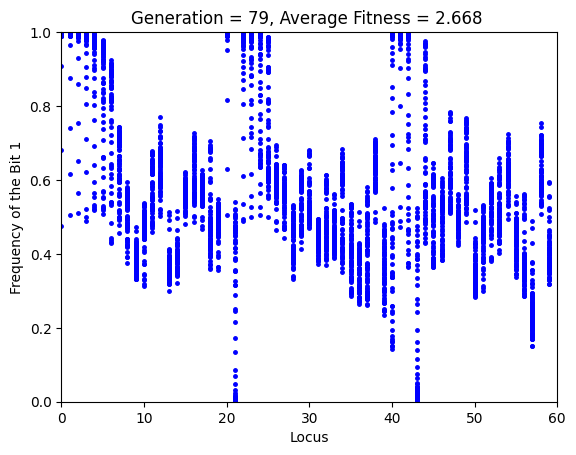

In [35]:
fobj = fITSE
strongersISE = ga.evolve(fitnessFunction=ga_fitting, 
          length=60, popSize=700, maxGens=80,
          probMutation=0.005)
 
chr = decode_chromosomes(strongersISE['DNA'], 3)
score = strongersISE['score'].max()
np.save('gaITSE_mf=' + str(round(strongersISE['score'].max(), 4))
, strongersISE['DNA'])

Default: 23.694122237519693
GA: 0.3529786856373221


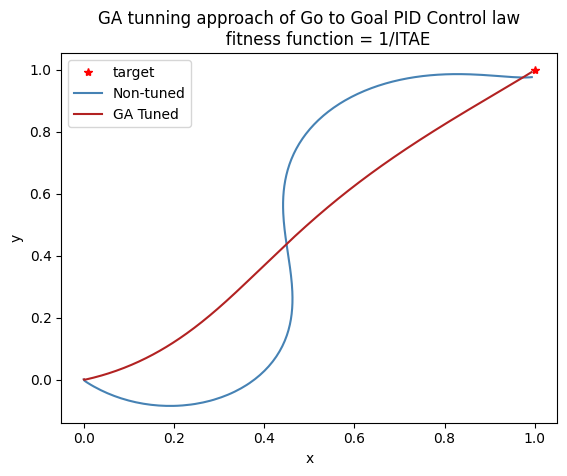

In [36]:
sol = solve_ivp(fun=pid_control_law, t_span=(0, 10), y0=initial_state,
                        args=[v0, .5, .5, .5, 50, target_pos])
sol0 = (sol.y[0], sol.y[1])
e = arctan2(sol.y[1], sol.y[0]) - sol.y[2]
print('Default:', fobj(sol.t, e))
kp, ki, kd = chr[-2]
sol = solve_ivp(fun=pid_control_law, t_span=(0, tf), y0=initial_state,
                        args=[v0, kp, ki, kd, pd, target_pos])

sol1 = (sol.y[0], sol.y[1])
x = sol.y[0]
y = sol.y[1]
phi = sol.y[2]
phi_d = arctan2(y, x)
e   = phi_d - phi
print('GA:', fobj(sol.t, e))

plot(target_pos[0], target_pos[1], '*', color='red')
plot(sol0[0], sol0[1], color='steelblue')
plot(sol1[0], sol1[1], color='firebrick')
# plot(sol0[0], sol0[1])
title('GA tunning approach of Go to Goal PID Control law\n \
      fitness function = 1/ITAE')
xlabel('x')
ylabel('y')
legend(['target','Non-tuned', 'GA Tuned'])

ITAE 	 kp=3.9966163635253906; ki=3.7622642517089844; kd=1.4752120971679688;
IAE 	 kp=3.979267120361328; ki=2.8572731018066406; kd=3.3423614501953125;
ISE 	 kp=3.9812583923339844; ki=3.114490509033203; kd=3.9909591674804688;
ITSE 	 kp=3.9980506896972656; ki=2.9810409545898438; kd=3.745086669921875;


Text(0, 0.5, 'y')

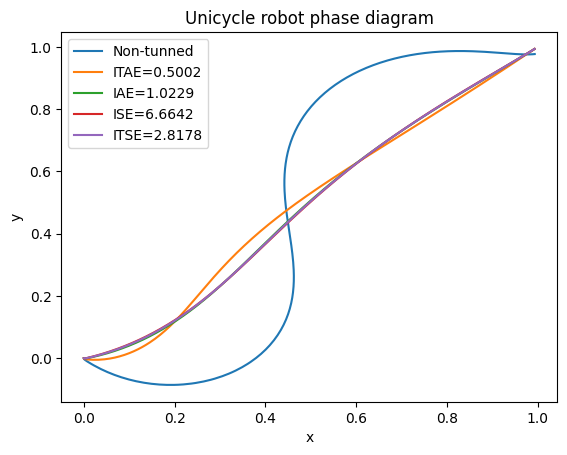

In [45]:
def load_bestindv(pop_path, fobj):
    pop = np.load(pop_path)
    gains = decode_chromosomes(pop, 3)
    maxScore = -np.inf
    strongest = (0, 0, 0)
    for g in gains[:-1]:
        kp = g[0]
        ki = g[1]
        kd = g[2]
        sol = solve_ivp(fun=pid_control_law, t_span=(0, tf), y0=initial_state,
                    args=[v0, kp, ki, kd, pd, target_pos])
        x = sol.y[0]
        y = sol.y[1]
        phi = sol.y[2]
        phi_d = arctan2(y, x)
        e   = phi_d - phi
        score = 1./fobj(sol.t, e)
        if score >= maxScore:
            strongest = (kp, ki, kd)
            maxScore = score
        # print(kp, ki, kd, score)
    maxScore = str(round(maxScore, 4))
    return strongest, maxScore, (x, y)


plot(sol0[0], sol0[1], label='Non-tunned')
path='populations\gaITAE_mf=0.4918.npy'
fobj = fITAE
k1, score, (x, y) = load_bestindv(path, fobj)
plot(x, y, label='ITAE='+score)

path='populations\gaIAE_mf=0.9934.npy'
k2, score, (x, y) = load_bestindv(path, fIAE)
plot(x, y, label='IAE='+score)

path='populations\gaISE_mf=4.8292.npy'
k3, score, (x, y) = load_bestindv(path, fISE)
plot(x, y,label='ISE='+score)
legend()

path='populations\gaITSE_mf=2.8099.npy'
k4, score, (x, y) = load_bestindv(path, fITSE)

controllers = [k1, k2, k3, k4]
methods = ['ITAE', 'IAE', 'ISE', 'ITSE']
for k, m in zip(controllers, methods):
    print(f'{m} \t kp={k[0]}; ki={k[1]}; kd={k[2]};') 

plot(x, y, label='ITSE='+score)
legend()
title('Unicycle robot phase diagram')
xlabel('x')
ylabel('y')

### Reference

https://www.ewh.ieee.org/soc/es/May2001/14/Begin.htm